In [1]:
import numpy as np
import pandas as pd
import scipy.linalg as la
import seaborn as sns
import matplotlib.pyplot as plt
import sghmc_algo as sghmc
from pyhmc import hmc
import pystan
from autograd import jacobian

## Example 1, pyhmc

In [3]:
def logprob(theta):
    logp = 2 * theta**2 - theta**4
    grad= 4 * theta - 4 * theta**3
    return logp, grad

theta0=np.array([0])

In [10]:
samp=hmc(logprob,x0=theta0,n_samples=10000)

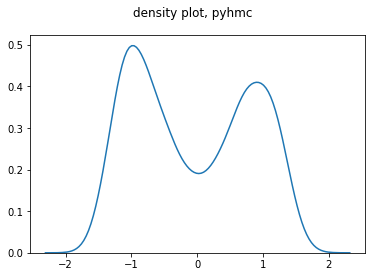

In [11]:
plt1 = sns.distplot(samp, kde = True, hist = False)
plt.suptitle("density plot, pyhmc")
fig1 = plt1.get_figure()
fig1.savefig("ex1-pyhmc.png")

## Example 1, pystan

In [2]:
model_ex1 = '''
    functions {
        # log probability density function
        real ex1_lpdf(real theta){return -1*(-2*theta^2+theta^4);}
    }
    data {
    }
    parameters {
        real theta;
    }
    model{
        theta ~ ex1_lpdf();
    }

'''

ex1_data = {}

sim_ex1 = pystan.StanModel(model_code = model_ex1)
fit = sim_ex1.sampling(data = ex1_data, iter = 10000, chains = 4)


INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_61da1ba4bf98848cc433e3943d42fce5 NOW.


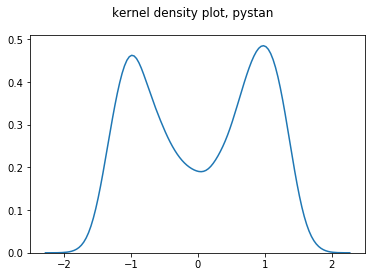

In [3]:
stanplt1 = sns.kdeplot(fit["theta"])
plt.suptitle("kernel density plot, pystan")
fig2 = stanplt1.get_figure()
fig2.savefig("ex1-pystan.png")

## Example 2, pyhmc

In [8]:
import autograd.numpy as np

In [9]:
def lprior(theta):
    return (-1/(2*10))*theta.T@theta

def ldatap(theta, x):
    return np.log(0.5 * np.exp(-0.5*(theta[0]-x)**2) + 0.5* np.exp(-0.5*(theta[1]-x)**2))

def U(theta, x, n, batch_size):
    return -lprior(theta) - (n/batch_size)*sum(ldatap(theta, x))

gradU = jacobian(U, argnum = 0)

def logprob(theta):
        logp = np.sum(U(theta, x=x, n=n, batch_size=n))
        gradu = gradU(theta, x=x, n=n, batch_size=n).reshape((-1,))
        return logp, gradu
    

mu = np.array([-3,3])
np.random.seed(123)
n = 200
x = np.r_[
    np.random.normal(mu[0], 1, n),
    np.random.normal(mu[1], 1, n)].reshape(-1,1)
eps = 0.01

In [10]:
sim_hmc = hmc(logprob, x0=mu.reshape(-1), n_samples=100, epsilon=0.01)

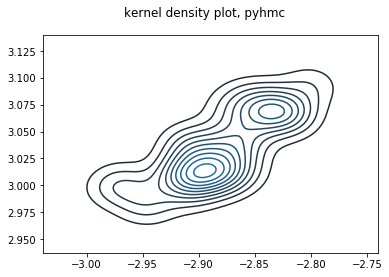

In [11]:
plt2 = sns.kdeplot(sim_hmc[:,0], sim_hmc[:,1])
plt.suptitle("kernel density plot, pyhmc")
fig3 = plt2.get_figure()
fig3.savefig("ex2-pyhmc.png")

## Example 2, pystan

In [30]:
np.random.seed(1234)
model_ex2 = '''
      data {
      int N;
      vector[N] y; #number of observations
      int n_groups; #number of mixture models
      vector<lower = 0>[n_groups] sigma; 
      vector<lower=0>[n_groups]  weights; 
    }
    parameters {
      vector[n_groups] mu; #unknown mu
    }
    model {
      vector[n_groups] contributions;
      mu ~ normal(0, 10);  
      
      # log likelihood
      for(i in 1:N) {
        for(k in 1:n_groups) {
          contributions[k] = log(weights[k]) + normal_lpdf(y[i] | mu[k], sigma[k]);
        }
        target += log_sum_exp(contributions);
      }
    }
'''

#set up data
p = 2
mu = np.array([-3,3]).reshape(2,1)
n = 200
x = np.r_[
    np.random.normal(mu[0], 1, n),
    np.random.normal(mu[1], 1, n)].flatten()
sigma = np.array([1,1])
weights = np.array([0.5,0.5])

ex2_data = {
    'N': len(x),
    'y': x,
    'n_groups': p,
    'sigma': sigma,
    'weights': weights
}

In [31]:
sim_stan = pystan.StanModel(model_code=model_ex2)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_0dbf2f5f08188fcc55e2951a8c55fd2c NOW.


In [41]:
fit_mn = sim_stan.sampling(data = ex2_data, iter = 3000, chains = 4)

/opt/conda/lib/python3.6/site-packages/seaborn/distributions.py:679: UserWarning: Passing a 2D dataset for a bivariate plot is deprecated in favor of kdeplot(x, y), and it will cause an error in future versions. Please update your code.
  warnings.warn(warn_msg, UserWarning)


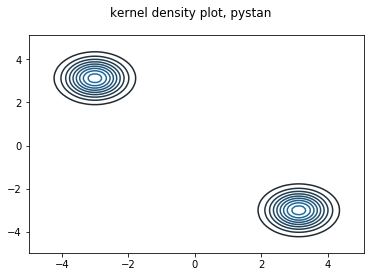

In [42]:
stanplt2 = sns.kdeplot(fit_mn["mu"])
plt.suptitle("kernel density plot, pystan")
fig4 = stanplt2.get_figure()
fig4.savefig("ex2-pystan.png")